# Signals Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import multiprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import scipy
from sklearn import tree
import sklearn
from sklearn import cross_validation
sns.set_context('notebook')

In [2]:
workingDirectory = '/home/jtao/analysis/signal_level_analysis/'

if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

## Functions

## Data Processing

### ATAC Peaks

In [31]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in os.listdir(atacTagDirPath):
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = tagDir + "_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    
scriptFile1.close()




In [32]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

	Fragment Length = 67
	Total Tags = 12733303.0
	Tags per bp = 0.006367
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 77
	Total Tags = 9726543.0
	Tags per bp = 0.004863
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 87
	Total Tags = 3551409.0
	Tags per bp = 0.001776
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 67
	Total Tags = 5746574.0
	Tags per bp = 0.002873
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
		Finding peaks on chr1 (minCount=-0.7), total tags positions = 170908
		Finding peaks on chr1 (minCount=-0.6), total tags positions = 273690
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 448119
		Finding peaks on chr2 (minCount=-0.7), total tags positions = 160142
		Finding peaks on chr1 (minCount=-0.0), total tags positions = 571010
		Findin

In [34]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
treatments = set([x.split('_')[3] for x in os.listdir(atacTagDirPath)])
for treatment in treatments:
    samples = [ x for x in os.listdir(atacTagDirPath) if treatment in x]
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            print(treatment,max_length)
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.01"
            else: 
                commandString += " -threshold 0.05"            
            commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./atac_idr/*’: No such file or directory
Veh 124766
KLA-1h 152283


In [30]:
%%bash
bash ./run_idr.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks.tsv, /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.02
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks.narrowPeak ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.narrowPeak --output-file ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.out --plot --idr-threshold 0.02 &
Performing IDR analysis on the following samples: /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2_peaks.tsv, /home/jt

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.06 1.41 0.92 0.61]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3.5-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 24073/54727 (44.0%)

Number of peaks passing IDR cutoff of 0.02 - 24073/54727 (44.0%)

/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  narrowPeakFrame['pValue'] = -1
Final parameter values: [2.64 1.64 0.96 0.66]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site

C57Bl6_Thiomac_ATAC_KLA-1h
C57Bl6_Thiomac_ATAC_Veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(....) is deprecated, use sort_index(.....)


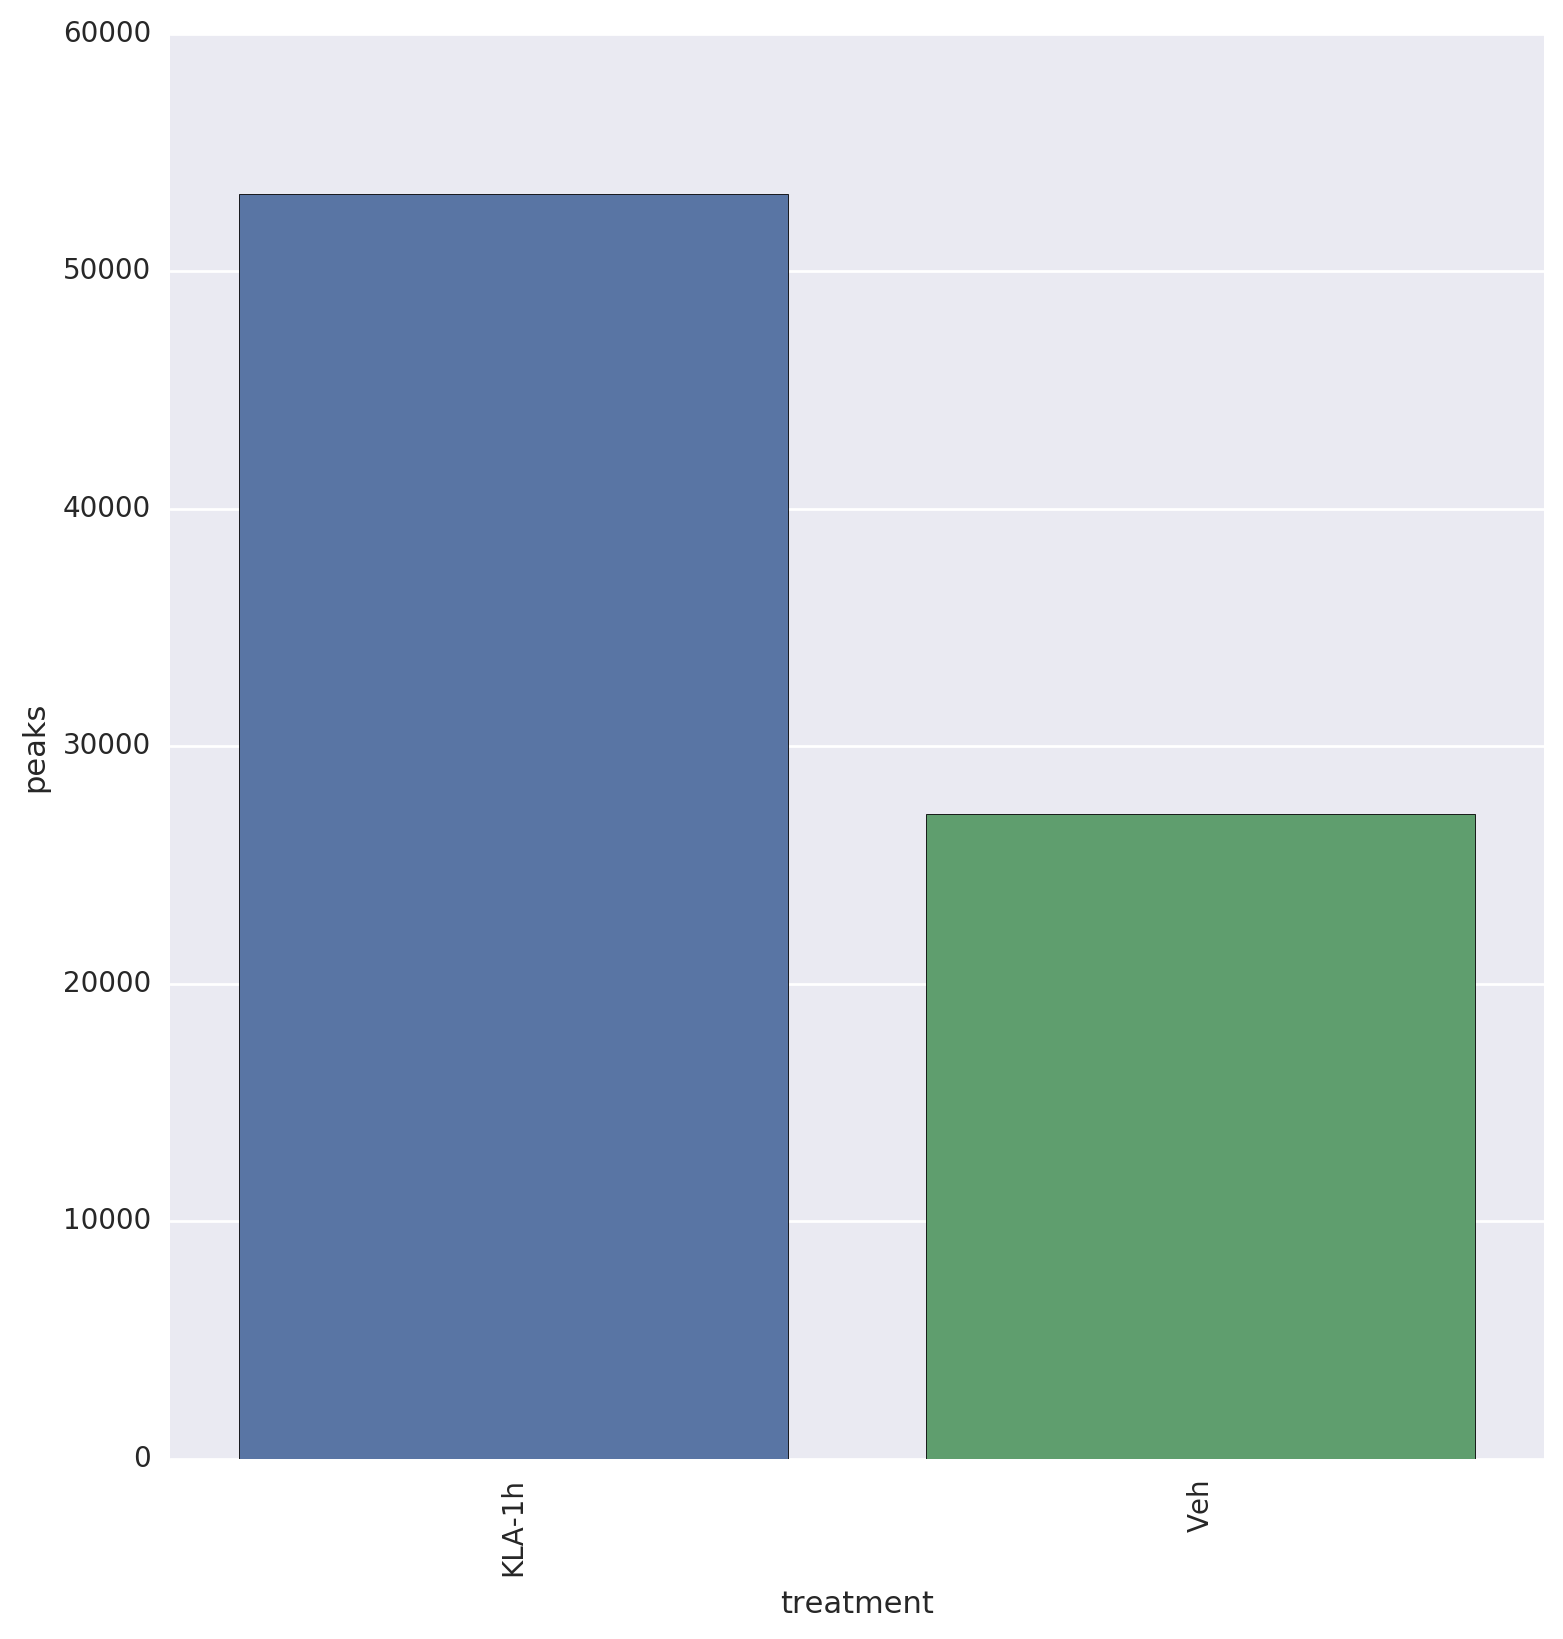

In [35]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:4])
        print(treatment)
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
    tokens = treatment.split('_')
    strains.append(tokens[0])
    treatments.append(tokens[3])
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [39]:
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[3]
    sample1 = '_'.join(tokens[:5])
    sample2 = '_'.join(tokens[7:13])
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath


C57Bl6	KLA-1h	C57Bl6_Thiomac_ATAC_KLA-1h_SD	C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1	C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2_peaks_C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1_peaks_idr.tsv
C57Bl6	Veh	C57Bl6_Thiomac_ATAC_Veh_SD	C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22	C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.tsv


In [40]:
target_peak_size = 100

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./atac_idr_peaks/'):
    current_peak_frame = pd.read_csv('./atac_idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [41]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [42]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 150
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Annotate Peaks

### ATAC

In [43]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -d ./tag_directories_atac/*/ > ./annotated_atac_peaks.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 56469
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 56469
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:....................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	448.0	19668322	0.085
		miRNA	2.0	

### GRO

In [ ]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -size 500 -fragLength 0 -d ./tag_directories_gro/*/ > ./annotated_gro_peaks.tsv

In [44]:
! makeSummaryFile.py ./merged_atac_peaks_filtered_resized.tsv ./group_atac_summary.tsv ./resized_peak_files/*

Finished reading merged peak file...
Integrating scores for C57Bl6_KLA-1h
Integrating scores for C57Bl6_Veh


### Differential ATAC Peaks

In [46]:
tag_dirs = sorted(os.listdir('./tag_directories_atac/'))
treated_dirs = ' '.join(['./tag_directories_atac/' + x for x in tag_dirs if not '_Veh_' in x])
veh_dirs = ' '.join(['./tag_directories_atac/' +x for x in tag_dirs if  '_Veh_' in x])
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d $veh_dirs $treated_dirs > ./annotated_atac_peaks_raw.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Will NOT normalize tag counts
	Tag Directories:
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 56469
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 56469
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:....................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	448.0	

In [47]:
with open('./annotated_atac_peaks_raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[19:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./annotated_atac_peaks_raw.tsv $condition_string -AvsA > edgeR_atac_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected annotatePeaks.pl file
	Output Stats Veh vs. KLA-1h:
		Total Genes: 56469
		Total Up-regulated in KLA-1h vs. Veh: 12317 (21.812%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh: 7399 (13.103%) [log2fold<-1, FDR<0.05]



## Differentially Expressed Genes

In [ ]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh' in x])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh' in x])

In [ ]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d $veh_dirs $treated_dirs > raw.tsv

In [ ]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d $veh_dirs $treated_dirs > rpkm.tsv

In [ ]:
with open('./raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[8:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./raw.tsv $condition_string -AvsA > edgeR_out.tsv

## Calculate Motif Scores

In [48]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [49]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_filtered_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_filtered_resized.bed
rm tmp


	Converted 56469 peaks total



In [50]:
!/gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py ./merged_atac_peaks_filtered_resized.bed mm10 ./merged_atac_peaks_filtered_resized.fasta

reading genome mm10


### All Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_all_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

rm: cannot remove ‘./motif_scores’: No such file or directory
AP-2_1_merged calculation time: 459.1206257343292
CTCF calculation time: 448.63721895217896
CP2-related_1_merged calculation time: 462.4680016040802
Bcl6 calculation time: 479.20519495010376
BCL6B calculation time: 482.94911313056946
E2F-related_2_merged calculation time: 457.9318928718567
DMRT3 calculation time: 467.9760615825653
E2F-related_3_merged calculation time: 461.35321855545044
Bach1::Mafk calculation time: 487.77032947540283
ATF4 calculation time: 502.0193283557892
Arid5a calculation time: 498.5609531402588
CREB-related_1_merged calculation time: 481.8361566066742
BARHL2 calculation time: 498.25181818008423
AP-2_2_merged calculation time: 507.17067074775696
Arid3a calculation time: 502.9049024581909
Brachyury-related_1_merged calculation time: 493.04406452178955
EBF1 calculation time: 466.5537440776825
Ddit3::Cebpa calculation time: 478.894544839859
Dux calculation time: 477.6055054664612
CENPB calculation time: 4

### Top Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./top_motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./top_motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

rm: cannot remove ‘./motif_scores’: No such file or directory
DMRT3 calculation time: 360.2284815311432
CP2-related_1_merged calculation time: 369.02230072021484
Brachyury-related_1_merged calculation time: 376.26801347732544
ATF4 calculation time: 391.7348816394806
EBF1 calculation time: 359.29960203170776
CTCF calculation time: 371.6599955558777
E2F-related_2_merged calculation time: 367.2333173751831
Bcl6 calculation time: 390.3344051837921
BCL6B calculation time: 393.72959566116333
Ahr::Arnt calculation time: 402.1710674762726
E2F-related_3_merged calculation time: 374.29560589790344
AP-2_1_merged calculation time: 409.707248210907
Ddit3::Cebpa calculation time: 384.4718368053436
Bach1::Mafk calculation time: 401.0715899467468
CEBPA calculation time: 396.7222349643707
CREB1 calculation time: 392.1004765033722
Arid5a calculation time: 407.82206678390503
E2F-related_1_merged calculation time: 386.09208393096924
CENPB calculation time: 399.3982057571411
Dux calculation time: 390.49075

## Read in Data

### Peak Data

In [45]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

summary_frame.to_pickle('summary_frame.pickle')

### ATAC Tag Data

### GRO Data

### Expression Data

In [ ]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame['All Gene Names'] = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.index = rpkm_frame['Gene'].values
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)
conditions = set(sorted([x.split('/')[-1].split('_')[3] for x in rpkm_frame.columns if 'tag_directories' in x]))
rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene', 'All Gene Names']]
for condition in conditions:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

### Diff Expression Data

In [ ]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

### Motifs

In [ ]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/'
all_motifs = []

for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_filtered_resized.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

### Identify Expressed Transcription Factors

In [ ]:
gene_motif_dict = {}
with open('/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/clustered_motifs/motifGene.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split()
    motif = tokens[0]
    genes = tokens[1].split('|')
    if motif in motif_size_dict:
        for g in genes:
            if g in gene_motif_dict:
                gene_motif_dict[g.upper()].append(motif)
            else:
                gene_motif_dict[g.upper()] = [motif]

In [ ]:
expression_threshold = 16
# thresholds = [1,2,4,8,16,32,64,128]
thresholds = range(100)
num_motifs = []
for expression_threshold in thresholds:
    motifs_at_threshold = []
    gene_names = rpkm_mean_frame[
        rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                    ].ix[:,'All Gene Names'].values
    for gn in gene_names:
        genes = gn.upper().split('|')
        for g in genes:
            if g in gene_motif_dict:
                motifs_at_threshold += gene_motif_dict[g]
    motifs_at_threshold = sorted(set(motifs_at_threshold))
    num_motifs.append(len(motifs_at_threshold))
plt.plot(thresholds, num_motifs) 
plt.xlabel('Expression Threshold (RPKM)')
plt.ylabel('Number of Motifs')

In [ ]:
expression_threshold = 20
motifs_to_include = []
gene_names = rpkm_mean_frame[
    rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                ].ix[:,'All Gene Names'].values
for gn in gene_names:
    genes = gn.upper().split('|')
    for g in genes:
        if g in gene_motif_dict:
            motifs_to_include += gene_motif_dict[g]
motifs_to_include = sorted(set(motifs_to_include))
print(len(set(motifs_to_include)))

### Motif Scores

#### All Motif Scores

In [ ]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted([x for x in os.listdir('./motif_scores') if x.split('.')[0] in motifs_to_include]):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))

#### Top Motif Scores

In [ ]:
topMotifScore_frame = pd.read_csv('./top_motif_scores/merged_atac_peaks_filtered_resized_motif_scores.tsv', 
                    sep='\t',
                    index_col= 0)

## Find Symmetric Motifs

In [ ]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][index]
        reverse_scores = motif_score_rc_dict[motif][index]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]

